# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# Load the model class and some custom functions
from models import get_vae_model, get_clustering_vae_model, compute_p, compute_delta
from evaluate_model import evaluate_clustering_performance
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

EPOCHS = 50
BATCH_SIZE = 128

model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_vae.encoder.summary()
# model_vae.decoder.summary()

In [5]:
model_vae.compile(optimizer=keras.optimizers.Adam())

model_vae.fit(x_train,
               epochs=EPOCHS,
               batch_size=128,
               verbose=2,
              )

# model_vae.save_weights("model_weights/cvae/pretrained/vae")

# model_vae.load_weights("model_weights/cvae/pretrained/vae")

Epoch 1/50
469/469 - 4s - total_loss: 33.4505 - reg_loss: 0.8166 - rec_loss: 32.6339 - 4s/epoch - 8ms/step
Epoch 2/50
469/469 - 2s - total_loss: 30.9054 - reg_loss: 1.8888 - rec_loss: 29.0166 - 2s/epoch - 5ms/step
Epoch 3/50
469/469 - 2s - total_loss: 29.3332 - reg_loss: 2.9280 - rec_loss: 26.4052 - 2s/epoch - 5ms/step
Epoch 4/50
469/469 - 2s - total_loss: 28.7977 - reg_loss: 3.2568 - rec_loss: 25.5409 - 2s/epoch - 5ms/step
Epoch 5/50
469/469 - 2s - total_loss: 28.4471 - reg_loss: 3.4801 - rec_loss: 24.9669 - 2s/epoch - 5ms/step
Epoch 6/50
469/469 - 2s - total_loss: 28.1920 - reg_loss: 3.6302 - rec_loss: 24.5619 - 2s/epoch - 5ms/step
Epoch 7/50
469/469 - 2s - total_loss: 28.0129 - reg_loss: 3.7215 - rec_loss: 24.2914 - 2s/epoch - 5ms/step
Epoch 8/50
469/469 - 2s - total_loss: 27.9068 - reg_loss: 3.7901 - rec_loss: 24.1167 - 2s/epoch - 5ms/step
Epoch 9/50
469/469 - 2s - total_loss: 27.8111 - reg_loss: 3.8557 - rec_loss: 23.9554 - 2s/epoch - 5ms/step
Epoch 10/50
469/469 - 2s - total_loss

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


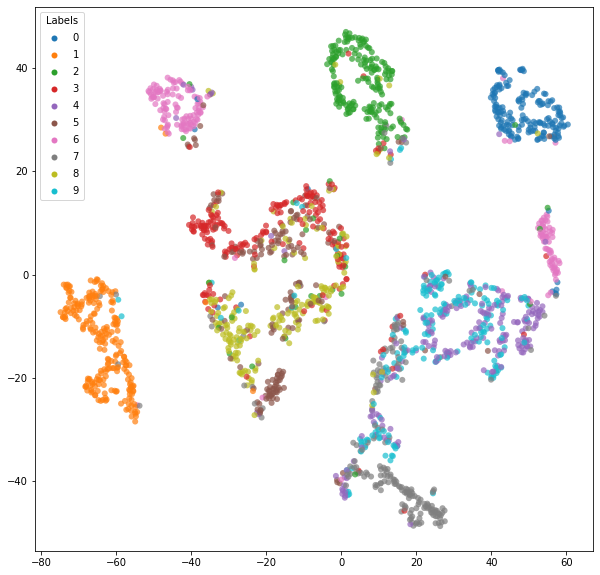

In [6]:
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_vae.encode_only_mu(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

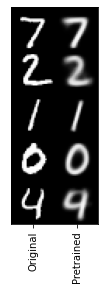

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_vae.encoder, model_vae.decoder, ("Original", "Pretrained"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

Construct the VaDE model:

In [9]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [10]:
z_train = model_cvae.encode_only_mu(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [11]:
p = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [12]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

Acc: 0.5070
ARI: 0.3074
AMI: 0.4494
Sil: 0.2216


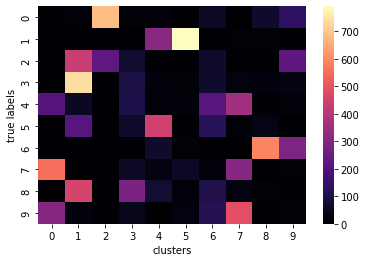

In [13]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

## Train the model

Train the model:

In [14]:
def cvae_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_cvae.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_cvae.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=cvae_callback)

In [15]:
model_cvae.compile(optimizer=keras.optimizers.Adam())

model_cvae.fit(x_train, p,
               epochs=EPOCHS,
               batch_size=128,
               callbacks = callback,
               verbose=2,
              )

# model_cvae.save_weights("model_weights/cvae/finetuned/cvae_kmeans")

# model_cvae.load_weights("model_weights/cvae/finetuned/cvae_kmeans")

Epoch 1/100
469/469 - 5s - total_loss: 145.1930 - reg_loss: 16.3776 - rec_loss: 22.2189 - clust_loss: 1065.9661 - 5s/epoch - 10ms/step
Epoch 2/100
469/469 - 3s - total_loss: 118.8037 - reg_loss: 20.2011 - rec_loss: 22.8529 - clust_loss: 757.4973 - 3s/epoch - 7ms/step
Epoch 3/100
469/469 - 4s - total_loss: 100.9150 - reg_loss: 22.0329 - rec_loss: 22.8731 - clust_loss: 560.0911 - 4s/epoch - 8ms/step
Epoch 4/100
469/469 - 4s - total_loss: 91.4171 - reg_loss: 23.6256 - rec_loss: 22.8186 - clust_loss: 449.7296 - 4s/epoch - 7ms/step
Epoch 5/100
469/469 - 3s - total_loss: 86.3009 - reg_loss: 25.0542 - rec_loss: 22.7266 - clust_loss: 385.1995 - 3s/epoch - 7ms/step
Epoch 6/100
469/469 - 4s - total_loss: 83.3176 - reg_loss: 26.3472 - rec_loss: 22.6244 - clust_loss: 343.4604 - 4s/epoch - 8ms/step
Epoch 7/100
469/469 - 4s - total_loss: 81.4823 - reg_loss: 27.4320 - rec_loss: 22.5823 - clust_loss: 314.6803 - 4s/epoch - 8ms/step
Epoch 8/100
469/469 - 4s - total_loss: 80.2755 - reg_loss: 28.3290 - re

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


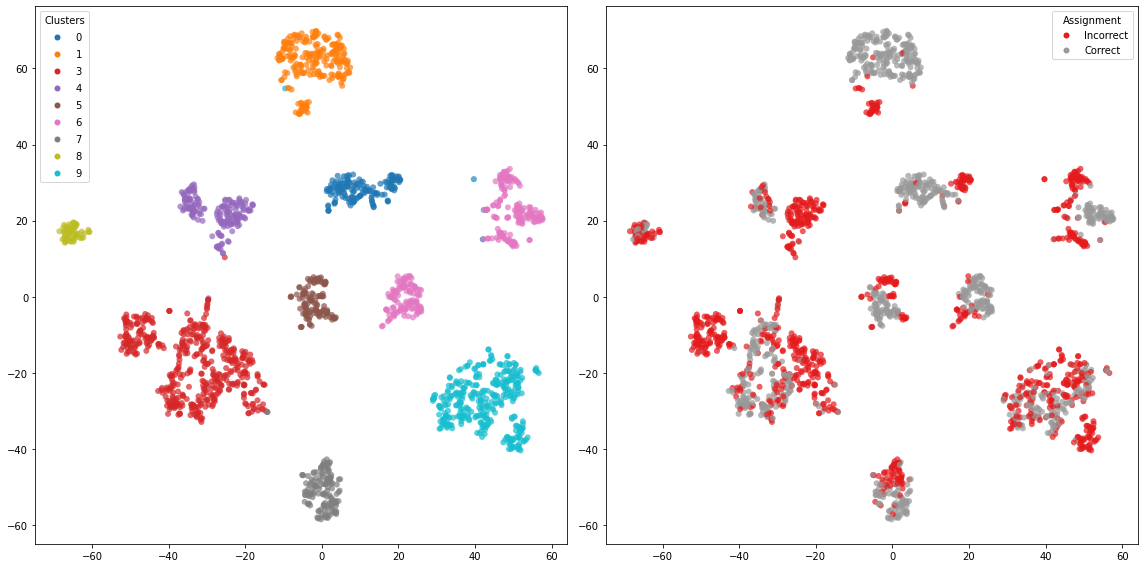

In [16]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

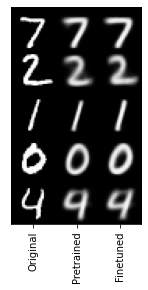

In [17]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.5242
ARI: 0.3356
AMI: 0.4923
Sil: 0.8983


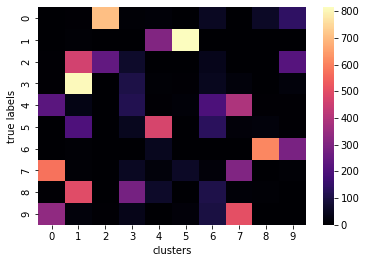

In [18]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [23]:
model_vae.load_weights("model_weights/cvae/pretrained/vae")

In [24]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_cvae = get_clustering_vae_model(model_vae, N_CLUSTERS, CLUSTERING_LOSS_WEIGHT)

## Initialize the parameters

In [25]:
z_train = model_cvae.encode_only_mu(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag')
gmm.fit(z_train)

for weight in model_cvae.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [26]:
p = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [27]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_vae.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

Acc: 0.4760
ARI: 0.2808
AMI: 0.4170
Sil: 0.1866


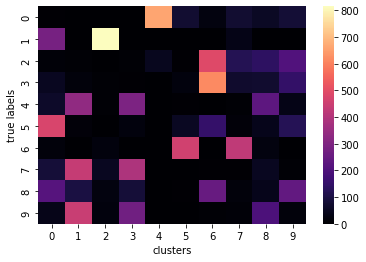

In [28]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)

## Train the model

In [29]:
model_cvae.compile(optimizer=keras.optimizers.Adam())

model_cvae.fit(x_train, p,
               epochs=EPOCHS,
               batch_size=128,
               callbacks = callback,
               verbose=2,
              )

# model_cvae.save_weights("model_weights/cvae/finetuned/cvae_gmm")

# model_cvae.load_weights("model_weights/cvae/finetuned/cvae_gmm")

Epoch 1/100
469/469 - 5s - total_loss: 153.7804 - reg_loss: 14.8090 - rec_loss: 22.2115 - clust_loss: 1167.5974 - 5s/epoch - 10ms/step
Epoch 2/100
469/469 - 3s - total_loss: 125.4180 - reg_loss: 19.1517 - rec_loss: 23.2330 - clust_loss: 830.3340 - 3s/epoch - 7ms/step
Epoch 3/100
469/469 - 3s - total_loss: 108.8347 - reg_loss: 21.1073 - rec_loss: 23.3776 - clust_loss: 643.4973 - 3s/epoch - 7ms/step
Epoch 4/100
469/469 - 3s - total_loss: 100.3239 - reg_loss: 22.7157 - rec_loss: 23.3175 - clust_loss: 542.9065 - 3s/epoch - 7ms/step
Epoch 5/100
469/469 - 3s - total_loss: 95.3366 - reg_loss: 24.1294 - rec_loss: 23.2250 - clust_loss: 479.8213 - 3s/epoch - 7ms/step
Epoch 6/100
469/469 - 4s - total_loss: 92.2515 - reg_loss: 25.2781 - rec_loss: 23.2123 - clust_loss: 437.6105 - 4s/epoch - 8ms/step
Epoch 7/100
469/469 - 3s - total_loss: 89.9989 - reg_loss: 26.2657 - rec_loss: 23.1461 - clust_loss: 405.8699 - 3s/epoch - 7ms/step
Epoch 8/100
469/469 - 3s - total_loss: 88.5301 - reg_loss: 27.0341 - r

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


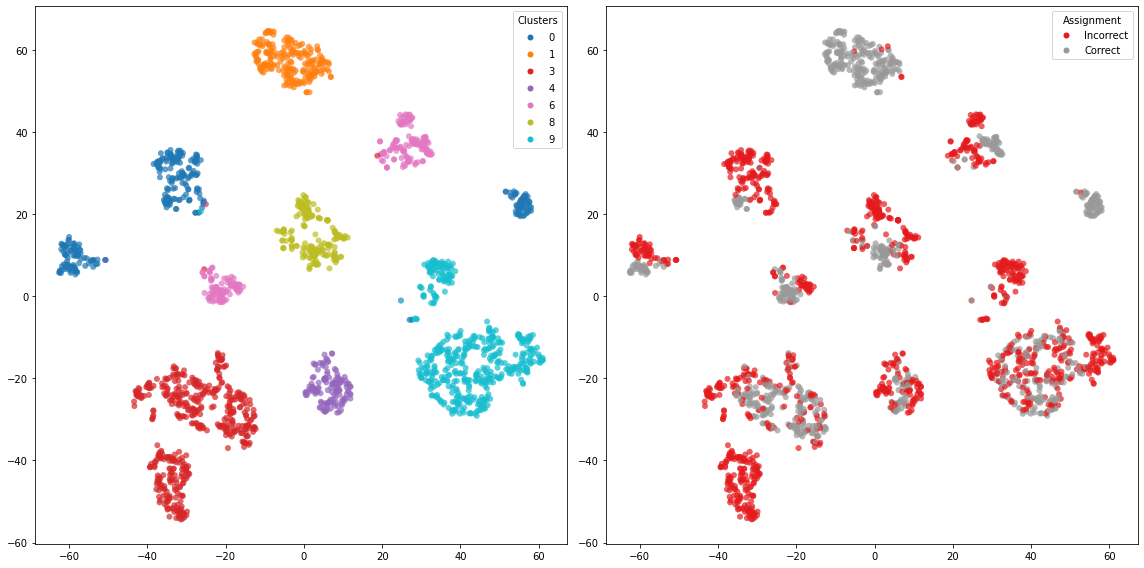

In [30]:
z_test = model_cvae.encode_only_mu(x_test)
c_test = model_cvae.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

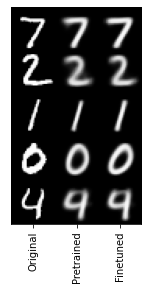

In [31]:
_ = compare_reconstructed_images_MNIST(x_test, model_cvae.encoder, model_cvae.decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

## Evaluate the model

Acc: 0.4652
ARI: 0.2871
AMI: 0.4282
Sil: 0.8943


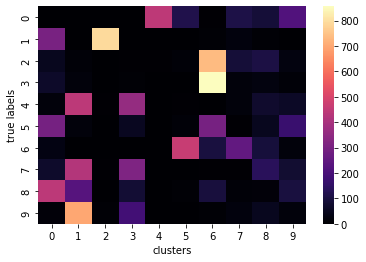

In [32]:
evaluate_clustering_performance(model_cvae.classify, x_test, y_test, True, model_cvae.encode_only_mu)